In [3]:
# Cell 1 — imports
import os
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

print("Libraries imported. CWD:", os.getcwd())

Libraries imported. CWD: /content


In [4]:
# Cell 2 — file paths (update if needed)
DATA_CSV = "/content/data_risk_scores.csv"
CODE_CSV = "/content/risk_scores.csv"

for p in (DATA_CSV, CODE_CSV):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Expected file '{p}' in working directory but it was not found. Please upload it.")
print("Both CSV files found.")

Both CSV files found.


In [5]:
# Cell 3 — load CSVs
df_data = pd.read_csv(DATA_CSV)
df_code = pd.read_csv(CODE_CSV)

print("data rows:", len(df_data), "columns:", df_data.columns.tolist())
print("code rows:", len(df_code), "columns:", df_code.columns.tolist())

data rows: 13204 columns: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects', 'reconstruction_mse', 'data_risk_score']
code rows: 1000 columns: ['code', 'true_label', 'predicted_label', 'risk_score']


In [6]:
# Cell 4 — validate columns and aggregate code_risk_score
if "data_risk_score" not in df_data.columns:
    matches = [c for c in df_data.columns if c.lower() == "data_risk_score"]
    if matches:
        df_data = df_data.rename(columns={matches[0]: "data_risk_score"})
    else:
        raise ValueError("data_risk_score column not found in data CSV.")

if "risk_score" not in df_code.columns:
    matches = [c for c in df_code.columns if c.lower() == "risk_score"]
    if matches:
        df_code = df_code.rename(columns={matches[0]: "risk_score"})
    else:
        raise ValueError("code risk score column not found in code CSV.")

# aggregate code_risk_score by mean and broadcast
code_scalar = float(df_code["risk_score"].astype(float).mean())
df_data = df_data.copy()
df_data["risk_score"] = code_scalar

print(f"Broadcasted code_risk_score mean={code_scalar:.6f} to all {len(df_data)} rows.")

Broadcasted code_risk_score mean=0.449955 to all 13204 rows.


In [7]:
# Cell 5 — prepare training data (label column 'defects' expected)
LABEL_COL = "defects"
if LABEL_COL not in df_data.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found in data CSV. Provide labels to train Model-C.")

df_model = df_data[["data_risk_score","risk_score", LABEL_COL]].dropna().rename(columns={LABEL_COL: "label"})
df_model["label"] = df_model["label"].astype(int)

X = df_model[["data_risk_score","risk_score"]].astype(float).values
y = df_model["label"].values

print("Rows available for training:", len(df_model))

Rows available for training: 13204


In [8]:
# Cell 6 — train model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))])
param_grid = {"clf__C": [0.01,0.1,1.0,10.0], "clf__class_weight": [None, "balanced"]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="average_precision", n_jobs=-1)
grid.fit(X_train, y_train)
best_clf = grid.best_estimator_
print("Best params:", grid.best_params_)

Best params: {'clf__C': 0.01, 'clf__class_weight': None}


In [9]:
# Cell 7 — calibrate and compute all probabilities
calibrator = CalibratedClassifierCV(best_clf, cv="prefit", method="sigmoid")
calibrator.fit(X_train, y_train)

X_all = df_data[["data_risk_score","risk_score"]].astype(float).values
probs_all = calibrator.predict_proba(X_all)[:,1]

# compute average
final_avg_score = float(probs_all.mean())
final_avg_score

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


0.15944272539306323

In [10]:
# Cell 8 — fixed thresholds and final print (ONLY ONE LINE)
# Fixed thresholds per your request:
thresholds_fixed = {"low_medium": 0.30, "medium_high": 0.60}

def format_incident_line_fixed(score, thresholds):
    score_rounded = round(float(score), 4)
    if score >= thresholds["medium_high"]:
        bucket = "HIGH"
    elif score >= thresholds["low_medium"]:
        bucket = "MEDIUM"
    else:
        bucket = "LOW"
    return f"Final Incident Score (average)={score_rounded:.4f} -> Probability of Incident={bucket}"

print(format_incident_line_fixed(final_avg_score, thresholds_fixed))

Final Incident Score (average)=0.1594 -> Probability of Incident=LOW


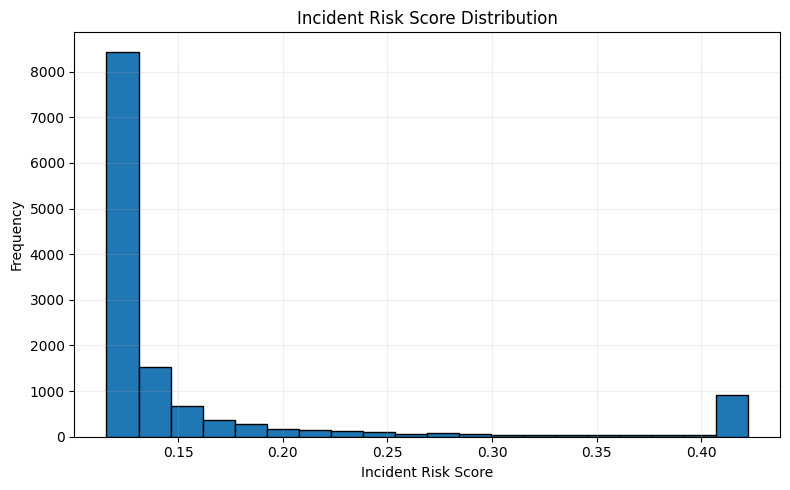

In [11]:
import matplotlib.pyplot as plt
import numpy as np


risk_scores = np.array(probs_all)


plt.figure(figsize=(8,5))

plt.hist(
    risk_scores,
    bins=20,
    edgecolor="black"
)

plt.title("Incident Risk Score Distribution")
plt.xlabel("Incident Risk Score")
plt.ylabel("Frequency")

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


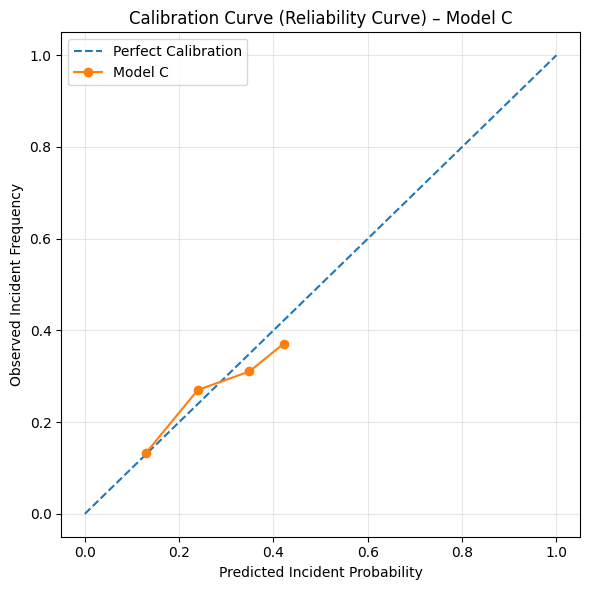

In [13]:
import numpy as np
import matplotlib.pyplot as plt

risk_scores = np.array(probs_all)   # predicted incident_risk_score (0–1)
true_labels = np.array(y)        # true incident labels (0 or 1)

num_bins = 10
bins = np.linspace(0.0, 1.0, num_bins + 1)
bin_ids = np.digitize(risk_scores, bins) - 1  # bin index for each sample

bin_centers = []
mean_pred = []
frac_positives = []

for b in range(num_bins):
    mask = bin_ids == b
    if np.sum(mask) == 0:   # skip empty bins
        continue
    bin_centers.append((bins[b] + bins[b+1]) / 2.0)
    mean_pred.append(risk_scores[mask].mean())
    frac_positives.append(true_labels[mask].mean())

# Plot Calibration (Reliability) Curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.plot(mean_pred, frac_positives, marker="o", label="Model C")

plt.xlabel("Predicted Incident Probability")
plt.ylabel("Observed Incident Frequency")
plt.title("Calibration Curve (Reliability Curve) – Model C")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
